In [2]:
library(ggplot2)
library(plyr)
library(dplyr)
library(tidyr)
library(magrittr)
library(lme4)
library(lmerTest)
library(GridLMM)
library(snpStats)

In [3]:
manhattanplot <- function(plot){
        don <- gwasResults %>% 

      # Compute chromosome size
      group_by(CHR) %>% 
      dplyr::summarise(chr_len=max(BP)) %>% 

      # Calculate cumulative position of each chromosome
      mutate(tot=cumsum(chr_len)-chr_len) %>%
      select(-chr_len) %>%

      # Add this info to the initial dataset
      left_join(gwasResults, ., by=c("CHR"="CHR")) %>%

      # Add a cumulative position of each SNP
      arrange(CHR, BP) %>%
      mutate( BPcum=BP+tot)

    axisdf = don %>% group_by(CHR) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )

    return(ggplot(don, aes(x=BPcum, y=-log10(P))) +

        # Show all points
        geom_point( aes(color=as.factor(CHR)), alpha=0.8, size=1.3) +
        scale_color_manual(values = rep(c("grey", "skyblue"), 22 )) +

        # custom X axis:
        scale_x_continuous( label = axisdf$CHR, breaks= axisdf$center ) +
        scale_y_continuous(expand = c(0, 0) ) +     # remove space between plot area and x axis
        ylim(0,7) +

        # Custom the theme:
        theme_bw() +
        theme( 
          legend.position="none",
          panel.border = element_blank(),
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank()
        ))
    }

In [5]:
traits <- c('movement_count','mean_movement_length','speed_in_movement_mean','dist_travelled')

pheno_df_ts <- read.csv("f1s_df_ts.csv")
pheno_df_36 <- read.csv("f1s_df_36.csv")

parents_df_ts <- read.csv("parents_df_ts.csv")
parents_df_36 <- read.csv("parents_df_36.csv")


In [6]:
grm <- as.matrix(read.table("female_parents.biSNP.sing.HW.gatk.GQfilter.MAF05.w100s1r08.rel"))
colnames(grm) <- rownames(grm) <- read.table("female_parents.biSNP.sing.HW.gatk.GQfilter.MAF05.w100s1r08.rel.id")[,2]

f1_grm <- grm[grep("F1",colnames(grm)),grep("F1",colnames(grm))]
p_grm <- grm[-grep("F1",colnames(grm)),-grep("F1",colnames(grm))]

f1s <- grep("_S",row.names(grm))
parental_grm <- as.matrix(grm)

family <- sapply(row.names(parental_grm),FUN=function(x){strsplit(x,"_")[[1]][4]})
row.names(parental_grm) <- colnames(parental_grm) <- family

In [7]:
pheno_df_ts <- pheno_df_ts[pheno_df_ts$Family %in% colnames(parental_grm),]

#Filtering as needed
combined_filtered_df <- pheno_df_ts
combined_filtered_df = combined_filtered_df[combined_filtered_df$Empty == F,]
combined_filtered_df = combined_filtered_df[!is.na(combined_filtered_df$Treatment),]
combined_filtered_df = combined_filtered_df[!is.na(combined_filtered_df$Batch),]

# Account for framerate
combined_filtered_df$dist_travelled <- combined_filtered_df$dist_travelled/10

#Ensure the flies still move some -- no dead flies!
# combined_filtered_df = combined_filtered_df[which(combined_filtered_df$movement_count > 10),]
# combined_filtered_df = combined_filtered_df[which(combined_filtered_df$movement_count < 10000),]
# combined_filtered_df = combined_filtered_df[which(combined_filtered_df$mean_of_mean_in_movement_speed < 100),]
combined_filtered_df = combined_filtered_df[combined_filtered_df$vel_par_in_movement_mean > 5 & combined_filtered_df$vel_par_in_movement_mean < 100,]
# combined_filtered_df <- combined_filtered_df[which(combined_filtered_df$speed_in_movement_var < 500),]
# combined_filtered_df <- combined_filtered_df[which(combined_filtered_df$mean_mov < 20000),]


pheno_df_ts <- combined_filtered_df

#Append meaningful individual ID
pheno_df_ts$indiv_id <- paste0(pheno_df_ts$Batch,"_",pheno_df_ts$Family,"_",pheno_df_ts$Well_orderAsTracked)

In [8]:
pheno_df_36 <- pheno_df_ts[pheno_df_36$Family %in% colnames(parental_grm),]

#Filtering as needed
combined_filtered_df <- pheno_df_36
combined_filtered_df = combined_filtered_df[combined_filtered_df$Empty == F,]
combined_filtered_df = combined_filtered_df[!is.na(combined_filtered_df$Treatment),]
combined_filtered_df = combined_filtered_df[!is.na(combined_filtered_df$Batch),]
# Account for framerate
combined_filtered_df$dist_travelled <- combined_filtered_df$dist_travelled/10

#Ensure the flies still move some -- no dead flies!
# combined_filtered_df = combined_filtered_df[which(combined_filtered_df$movement_count > 10),]
# combined_filtered_df = combined_filtered_df[which(combined_filtered_df$movement_count < 10000),]
# combined_filtered_df = combined_filtered_df[which(combined_filtered_df$mean_of_mean_in_movement_speed < 100),]
combined_filtered_df = combined_filtered_df[combined_filtered_df$vel_par_in_movement_mean > 5 & combined_filtered_df$vel_par_in_movement_mean < 100,]
# combined_filtered_df <- combined_filtered_df[which(combined_filtered_df$speed_in_movement_var < 500),]
# combined_filtered_df <- combined_filtered_df[which(combined_filtered_df$mean_mov < 20000),]


pheno_df_36 <- combined_filtered_df

#Append meaningful individual ID
pheno_df_36$indiv_id <- paste0(pheno_df_36$Batch,"_",pheno_df_36$Family,"_",pheno_df_36$Well_orderAsTracked)

In [9]:
path <- paste("female_parents.biSNP.sing.HW.gatk.GQfilter.MAF05.w100s1r08", c(".bed", ".bim", ".fam"), sep = "")
SNPs <- read.plink(path[1], path[2], path[3])

genotype_mat <- as(SNPs$genotypes,"numeric")
row.names(genotype_mat) <- sapply(row.names(genotype_mat),FUN=function(x){strsplit(x,"_")[[1]][4]})

strs <- sapply(unique(pheno_df_ts$Family),toString)

# Expand genotype matrix to fit phenotype vector length
gt_mat <- genotype_mat[strs,]


mean_filled_gt_mat = gt_mat

fillNAX= TRUE
if(sum(is.na(mean_filled_gt_mat))>0){
    if(fillNAX){
      mean_filled_gt_mat = apply(mean_filled_gt_mat,2,function(x) {
        if(sum(is.na(x)) > 0){
          x[is.na(x)] = mean(x,na.rm=T)
        }
        x
      })
    } else{
      mean_filled_gt_mat[,colSums(is.na(X))>1] = 0
    }
  }

name_split <- sapply(colnames(gt_mat),FUN=function(x){strsplit(x,split=c("\\["))[[1]][1]})
chr <- sapply(name_split,FUN=function(x){strsplit(x,split=":")[[1]][1]})
pos <- as.numeric(sapply(name_split,FUN=function(x){strsplit(x,split=":")[[1]][2]}))

map_g = data.frame(snp = name_split,chr = chr, pos=pos,ref=rep("A",ncol(gt_mat)),alt=rep("T",ncol(gt_mat)))
# chr <- mapvalues(map_g$chr,unique(map_g$chr),c(1,2,3,4,5,6))

In [10]:
# A simple match so it is a bit easier to create the mapped data set
Mode <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}

# Select slicetime and treatments of interest and get group mean (along with batch, camera, and plate)
mapping_df_0to4 <- pheno_df_ts[pheno_df_ts$slicetime == 0 & pheno_df_ts$Treatment %in% c("C","HS","R"),] %>% dplyr::group_by(Family,Treatment) %>% dplyr::summarize(dist_travelled = mean(dist_travelled, na.rm = TRUE),
    mean_movement_length = mean(mean_movement_length, na.rm = TRUE),movement_count = mean(movement_count, na.rm = TRUE),
    speed_in_movement_mean = mean(speed_in_movement_mean, na.rm = TRUE), batch = Mode(Batch), camera = Mode(Camera), plate = Mode(Plate))

mapping_df_32to36 <- pheno_df_ts[pheno_df_ts$slicetime == 32 & pheno_df_ts$Treatment %in% c("C","HS","R"),] %>% dplyr::group_by(Family,Treatment) %>% dplyr::summarize(dist_travelled = mean(dist_travelled, na.rm = TRUE),
    mean_movement_length = mean(mean_movement_length, na.rm = TRUE),movement_count = mean(movement_count, na.rm = TRUE),
    speed_in_movement_mean = mean(speed_in_movement_mean, na.rm = TRUE), batch = Mode(Batch), camera = Mode(Camera), plate = Mode(Plate))

mapping_df_0to36 <- pheno_df_36 %>% dplyr::group_by(Family,Treatment) %>% dplyr::summarize(dist_travelled = mean(dist_travelled, na.rm = TRUE),
    mean_movement_length = mean(mean_movement_length, na.rm = TRUE),movement_count = mean(movement_count, na.rm = TRUE),
    speed_in_movement_mean = mean(speed_in_movement_mean, na.rm = TRUE), batch = Mode(Batch), camera = Mode(Camera), plate = Mode(Plate))

`summarise()` has grouped output by 'Family'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Family'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Family'. You can override using the `.groups` argument.



In [11]:
# Regress out fixed effects before grouping into
pheno_df_ts_reg <- pheno_df_ts
pheno_df_ts_reg$dist_travelled <- residuals(lm(dist_travelled ~ 1 + Batch + Camera + Plate ,pheno_df_ts))
pheno_df_ts_reg$movement_count <- residuals(lm(movement_count ~ 1 + Batch + Camera + Plate ,pheno_df_ts))
pheno_df_ts_reg$mean_movement_length <- residuals(lm(mean_movement_length ~ 1 + Batch + Camera + Plate ,pheno_df_ts))
pheno_df_ts_reg$speed_in_movement_mean <- residuals(lm(speed_in_movement_mean ~ 1 + Batch + Camera + Plate ,pheno_df_ts))

# Select slicetime and treatments of interest and get group mean (along with batch, camera, and plate)
mapping_df_0to4_regressed <- pheno_df_ts_reg[pheno_df_ts$slicetime == 0 & pheno_df_ts$Treatment %in% c("C","HS","R"),] %>% 
    dplyr::group_by(Family,Treatment) %>% 
    dplyr::summarize(dist_travelled = mean(dist_travelled, na.rm = TRUE),
                     mean_movement_length = mean(mean_movement_length, na.rm = TRUE),
                     movement_count = mean(movement_count, na.rm = TRUE),
                     speed_in_movement_mean = mean(speed_in_movement_mean, na.rm = TRUE), 
                     batch = Mode(Batch), camera = Mode(Camera), plate = Mode(Plate))

mapping_df_32to36_regressed <- pheno_df_ts_reg[pheno_df_ts$slicetime == 32 & pheno_df_ts$Treatment %in% c("C","HS","R"),] %>% 
    dplyr::group_by(Family,Treatment) %>% 
    dplyr::summarize(dist_travelled = mean(dist_travelled, na.rm = TRUE),
                     mean_movement_length = mean(mean_movement_length, na.rm = TRUE),
                     movement_count = mean(movement_count, na.rm = TRUE),
                     speed_in_movement_mean = mean(speed_in_movement_mean, na.rm = TRUE), 
                     batch = Mode(Batch), camera = Mode(Camera), plate = Mode(Plate))



`summarise()` has grouped output by 'Family'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Family'. You can override using the `.groups` argument.



In [ ]:
# null_model = GridLMM_ML(paste(trait, '1 + Treatment + (1 + Treatment | Family)',
#                                                      sep = ' ~ '),mapping_df,relmat = list(Family = parental_grm),tolerance = 1e-3,save_V_folder = 'V_folder',)
# RE_setup = null_model$setup$RE_setup
# full_RE_names = names(RE_setup)
# names(RE_setup) = c('G','GxE_HS','GxE_R')

# null_model$results

# h2_start <- null_model$results[,c('Family..Intercept..REML','Family.TreatmentHS.REML','Family.TreatmentR.REML')]

In [ ]:
# out_0to4_grm = list()
# for (i in 1:4){
#     print(i)
#     trait = traits[i]
#     print(trait)
#     mother_mean_mod <- GridLMM_GWAS(as.formula(paste(trait, '1 + batch + plate + camera + Treatment + (1 + Treatment | Family)',
#                                                      sep = ' ~ ')),~1 + Treatment,~1,data=mapping_df_0to4, X = mean_filled_gt_mat,
#                                                      X_ID = 'Family', relmat = list(Family = parental_grm))
#     out_0to4_grm[[i]] <- mother_mean_mod
# }

In [12]:
out_0to4_grm_regressed = list()
for (i in 1:4){
    print(i)
    trait = traits[i]
    print(trait)
    trait_formula <- as.formula(paste(trait, '1 + Treatment + (1 + Treatment | Family)', sep = ' ~ '))
    mother_mean_mod <- GridLMM_GWAS(trait_formula,
                                    ~1 + Treatment,
                                    ~1,
                                    data=mapping_df_0to4_regressed, 
                                    X = mean_filled_gt_mat,
                                    X_ID = 'Family', 
                                    relmat = list(Family = parental_grm))
     out_0to4_grm_regressed[[i]] <- mother_mean_mod
}

[1] 1
[1] "movement_count"
[1] "Estimating h2_start via null model"
[1] "step_size: 0.5, num_to_test: 4"
[1] "step_size: 0.25, num_to_test: 7"
[1] "step_size: 0.125, num_to_test: 7"
[1] "step_size: 0.125, num_to_test: 3"
[1] "step_size: 0.0625, num_to_test: 11"
[1] "step_size: 0.0625, num_to_test: 8"
[1] "step_size: 0.03125, num_to_test: 26"
[1] "step_size: 0.03125, num_to_test: 2"
[1] "step_size: 0.015625, num_to_test: 17"
[1] "step_size: 0.015625, num_to_test: 5"
[1] "step_size: 0.0078125, num_to_test: 17"
[1] "step_size: 0.00390625, num_to_test: 17"
[1] "step_size: 0.00390625, num_to_test: 5"
[1] "step_size: 0.001953125, num_to_test: 28"
[1] "GridLMM_posterior h2s:"
     Family..Intercept. Family.TreatmentHS Family.TreatmentR
[1,]           0.671875         0.02734375                 0
[1] "step: 1, num_h2s: 1, num active: 565448"
[1] "step: 2, num_h2s: 17, num active: 565448"
[1] "step: 3, num_h2s: 50, num active: 121763"
[1] "step: 4, num_h2s: 37, num active: 8527"
[1] "step: 5, n

In [ ]:
# # Map using GridLMM -- parental grm covariance matrix for family effect
# # https://github.com/deruncie/GridLMM/blob/master/vignettes/Running_GridLMM_GWAS.Rmd for an example

# out_32to36_grm = list()
# for (i in 1:4){
#     print(i)
#     trait = traits[i]
#     print(trait)
#     mother_mean_mod <- GridLMM_GWAS(as.formula(paste(trait, '1 + batch + plate + camera + Treatment + (1 + Treatment | Family)',
#                                                      sep = ' ~ ')),~1 + Treatment,~1,data=mapping_df_32to36, X = mean_filled_gt_mat,
#                                                      X_ID = 'Family', relmat = list(Family = parental_grm))
#     out_32to36_grm[[i]] <- mother_mean_mod
# }

In [ ]:
out_32to36_grm_regressed = list()
for (i in 1:4){
    trait = traits[i]
    print(trait)
    trait_formula <- as.formula(paste(trait, '1 + Treatment + (1 + Treatment | Family)', sep = ' ~ '))
    mother_mean_mod <- GridLMM_GWAS(trait_formula,
                                    ~1 + Treatment,
                                    ~1,
                                    data = mapping_df_32to36_regressed,
                                    X = mean_filled_gt_mat,
                                    X_ID = 'Family', 
                                    relmat = list(Family = parental_grm),
                                    algorithm="Fast")
    out_32to36_grm_regressed[[i]] <- mother_mean_mod
}

In [ ]:
out_32to36_grm_regressed[[1]][[1]]

In [11]:
print("done")

[1] "done"


In [ ]:
# # Map using GridLMM -- parental grm covariance matrix for family effect
# # https://github.com/deruncie/GridLMM/blob/master/vignettes/Running_GridLMM_GWAS.Rmd for an example

# out_36_grm = list()
# for (i in 1:4){
#     print(i)
#     trait = traits[i]
#     print(trait)
#     mother_mean_mod <- GridLMM_GWAS(as.formula(paste(trait, '1 + batch + plate + camera + Treatment + (1 + Treatment | Family)',
#                                                      sep = ' ~ ')),~1 + Treatment,~1,data=mapping_df_36, X = mean_filled_gt_mat,
#                                                      X_ID = 'Family', relmat = list(Family = parental_grm))
#     out_36_grm[[i]] <- mother_mean_mod
# }

In [22]:
i = 1
print(traits[i])
output = out_32_grm[[i]] # Trait 1 = traits[1]
trait = traits[i]

as.data.frame(output)

[1] "movement_count"


ERROR: Error in eval(expr, envir, enclos): object 'out_32_grm' not found


In [ ]:
i = 1
print(traits[i])
output = out_0to36_grm[[i]] # Trait 1 = traits[1]
trait = traits[i]

qq::qq_plot(output$results$p_value_REML.1) + ggtitle(paste0("GridLMM: Control - Main Effect - ", traits[i]))
ggsave(paste0("plots/0to36_GRM_qq_Ctrl_",trait,".png"))
gwasResults <- data.frame(BP = map_g$pos[1:length(output$results$p_value_REML.1)], CHR=chr[1:length(output$results$p_value_REML.1)], P = output$results$p_value_REML.1)
gwasResults <- gwasResults[!is.na(gwasResults$P),]
manhattanplot(gwasResults) + ggtitle(paste0("GridLMM: Control - Main Effect - ", traits[i]))
ggsave(paste0("plots/0to36_GRM_manh_Ctrl_",trait,".png"))

qq::qq_plot(output$results$p_value_REML.2) + ggtitle(paste0("GridLMM: GxE Effect - HS - ", traits[i]))
ggsave(paste0("plots/0to36_GRM_qq_GxE_HS_",trait,".png"))
gwasResults <- data.frame(BP = map_g$pos[1:length(output$results$p_value_REML.2)], CHR=chr[1:length(output$results$p_value_REML.2)], P = output$results$p_value_REML.2)
gwasResults <- gwasResults[!is.na(gwasResults$P),]
manhattanplot(gwasResults) + ggtitle(paste0("GridLMM: GxE Effect - HS - ", traits[i]))
ggsave(paste0("plots/0to36_GRM_manh_GxE_HS_",trait,".png"))

qq::qq_plot(output$results$p_value_REML.3) + ggtitle(paste0("GridLMM: GxE Effect - R - ", traits[i]))
ggsave(paste0("plots/0to36_GRM_qq_GxE_R_",trait,".png"))
gwasResults <- data.frame(BP = map_g$pos[1:length(output$results$p_value_REML.3)], CHR=chr[1:length(output$results$p_value_REML.3)], P = output$results$p_value_REML.3)
gwasResults <- gwasResults[!is.na(gwasResults$P),]
manhattanplot(gwasResults) + ggtitle(paste0("GridLMM: GxE Effect - R - ", traits[i]))
ggsave(paste0("plots/0to36_GRM_manh_GxE_R_",trait,".png"))

In [ ]:
i = 2
print(traits[i])
output = out_0to4_grm[[i]] # Trait 1 = traits[1]
trait = traits[i]

qq::qq_plot(output$results$p_value_REML.1) + ggtitle(paste0("GridLMM: Control - Main Effect - ", traits[i]))
ggsave(paste0("plots/T0_GRM_qq_Ctrl_",trait,".png"))
gwasResults <- data.frame(BP = map_g$pos[1:length(output$results$p_value_REML.1)], CHR=chr[1:length(output$results$p_value_REML.1)], P = output$results$p_value_REML.1)
gwasResults <- gwasResults[!is.na(gwasResults$P),]
manhattanplot(gwasResults) + ggtitle(paste0("GridLMM: Control - Main Effect - ", traits[i]))
ggsave(paste0("plots/T0_GRM_manh_Ctrl_",trait,".png"))

qq::qq_plot(output$results$p_value_REML.2) + ggtitle(paste0("GridLMM: GxE Effect - HS - ", traits[i]))
ggsave(paste0("plots/T0_GRM_qq_GxE_HS_",trait,".png"))
gwasResults <- data.frame(BP = map_g$pos[1:length(output$results$p_value_REML.2)], CHR=chr[1:length(output$results$p_value_REML.2)], P = output$results$p_value_REML.2)
gwasResults <- gwasResults[!is.na(gwasResults$P),]
manhattanplot(gwasResults) + ggtitle(paste0("GridLMM: GxE Effect - HS - ", traits[i]))
ggsave(paste0("plots/T0_GRM_manh_GxE_HS_",trait,".png"))

qq::qq_plot(output$results$p_value_REML.3) + ggtitle(paste0("GridLMM: GxE Effect - R - ", traits[i]))
ggsave(paste0("plots/T0_GRM_qq_GxE_R_",trait,".png"))
gwasResults <- data.frame(BP = map_g$pos[1:length(output$results$p_value_REML.3)], CHR=chr[1:length(output$results$p_value_REML.3)], P = output$results$p_value_REML.3)
gwasResults <- gwasResults[!is.na(gwasResults$P),]
manhattanplot(gwasResults) + ggtitle(paste0("GridLMM: GxE Effect - R - ", traits[i]))
ggsave(paste0("plots/T0_GRM_manh_GxE_R_",trait,".png"))

In [ ]:
i = 1
print(traits[i])
output = out_32to36_grm[[i]] # Trait 1 = traits[1]
trait = traits[i]

qq::qq_plot(output$results$p_value_REML.1) + ggtitle(paste0("GridLMM: Control - Main Effect - ", traits[i]))
ggsave(paste0("plots/T32_GRM_qq_Ctrl_",trait,".png"))
gwasResults <- data.frame(BP = map_g$pos[1:length(output$results$p_value_REML.1)], CHR=chr[1:length(output$results$p_value_REML.1)], P = output$results$p_value_REML.1)
gwasResults <- gwasResults[!is.na(gwasResults$P),]
manhattanplot(gwasResults) + ggtitle(paste0("GridLMM: Control - Main Effect - ", traits[i]))
ggsave(paste0("plots/T32_GRM_manh_Ctrl_",trait,".png"))

qq::qq_plot(output$results$p_value_REML.2) + ggtitle(paste0("GridLMM: GxE Effect - HS - ", traits[i]))
ggsave(paste0("plots/T32_GRM_qq_GxE_HS_",trait,".png"))
gwasResults <- data.frame(BP = map_g$pos[1:length(output$results$p_value_REML.2)], CHR=chr[1:length(output$results$p_value_REML.2)], P = output$results$p_value_REML.2)
gwasResults <- gwasResults[!is.na(gwasResults$P),]
manhattanplot(gwasResults) + ggtitle(paste0("GridLMM: GxE Effect - HS - ", traits[i]))
ggsave(paste0("plots/T32_GRM_manh_GxE_HS_",trait,".png"))

qq::qq_plot(output$results$p_value_REML.3) + ggtitle(paste0("GridLMM: GxE Effect - R - ", traits[i]))
ggsave(paste0("plots/T32_GRM_qq_GxE_R_",trait,".png"))
gwasResults <- data.frame(BP = map_g$pos[1:length(output$results$p_value_REML.3)], CHR=chr[1:length(output$results$p_value_REML.3)], P = output$results$p_value_REML.3)
gwasResults <- gwasResults[!is.na(gwasResults$P),]
manhattanplot(gwasResults) + ggtitle(paste0("GridLMM: GxE Effect - R - ", traits[i]))
ggsave(paste0("plots/T32_GRM_manh_GxE_R_",trait,".png"))

[1] "movement_count"


Warning message:
“`data_frame()` was deprecated in tibble 1.1.0.
Please use `tibble()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
Warning message:
“Removed 1 rows containing missing values (geom_abline).”
Saving 6.67 x 6.67 in image



ERROR: Error in grid.newpage(): could not open file 'plots/T32_GRM_qq_Ctrl_movement_count.png'


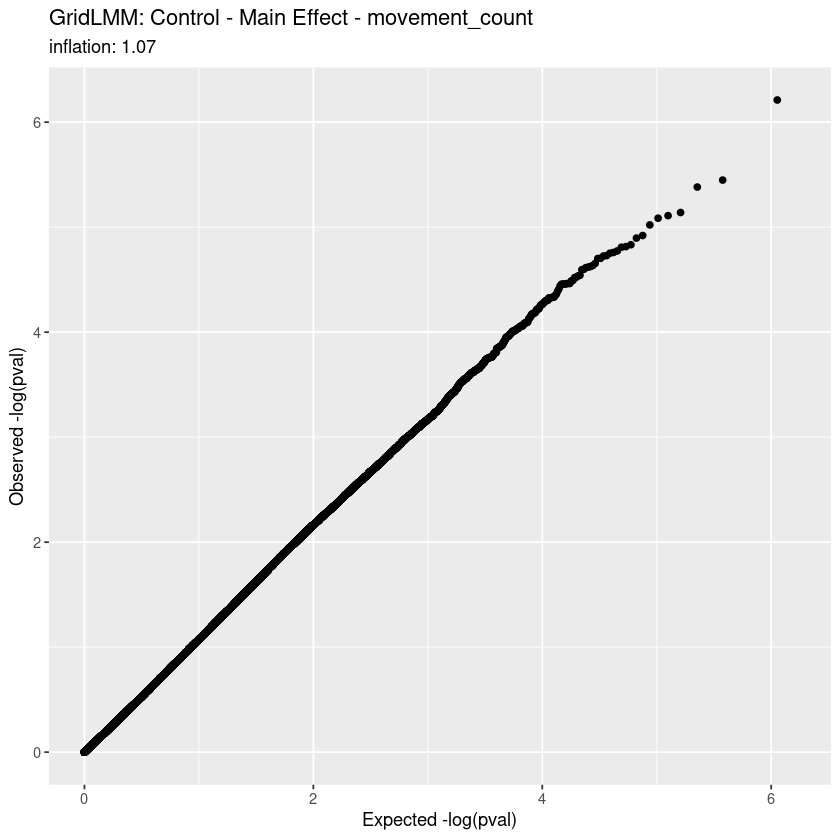

In [25]:
i = 1
print(traits[i])
output = out_32to36_grm_regressed[[i]] # Trait 1 = traits[1]
trait = traits[i]

qq::qq_plot(output$results$p_value_REML.1) + ggtitle(paste0("GridLMM: Control - Main Effect - ", traits[i]))
ggsave(paste0("plots/T32_GRM_qq_Ctrl_",trait,".png"))
gwasResults <- data.frame(BP = map_g$pos[1:length(output$results$p_value_REML.1)], CHR=chr[1:length(output$results$p_value_REML.1)], P = output$results$p_value_REML.1)
gwasResults <- gwasResults[!is.na(gwasResults$P),]
manhattanplot(gwasResults) + ggtitle(paste0("GridLMM: Control - Main Effect - ", traits[i]))
ggsave(paste0("plots/T32_GRM_manh_Ctrl_",trait,".png"))

qq::qq_plot(output$results$p_value_REML.2) + ggtitle(paste0("GridLMM: GxE Effect - HS - ", traits[i]))
ggsave(paste0("plots/T32_GRM_qq_GxE_HS_",trait,".png"))
gwasResults <- data.frame(BP = map_g$pos[1:length(output$results$p_value_REML.2)], CHR=chr[1:length(output$results$p_value_REML.2)], P = output$results$p_value_REML.2)
gwasResults <- gwasResults[!is.na(gwasResults$P),]
manhattanplot(gwasResults) + ggtitle(paste0("GridLMM: GxE Effect - HS - ", traits[i]))
ggsave(paste0("plots/T32_GRM_manh_GxE_HS_",trait,".png"))

qq::qq_plot(output$results$p_value_REML.3) + ggtitle(paste0("GridLMM: GxE Effect - R - ", traits[i]))
ggsave(paste0("plots/T32_GRM_qq_GxE_R_",trait,".png"))
gwasResults <- data.frame(BP = map_g$pos[1:length(output$results$p_value_REML.3)], CHR=chr[1:length(output$results$p_value_REML.3)], P = output$results$p_value_REML.3)
gwasResults <- gwasResults[!is.na(gwasResults$P),]
manhattanplot(gwasResults) + ggtitle(paste0("GridLMM: GxE Effect - R - ", traits[i]))
ggsave(paste0("plots/T32_GRM_manh_GxE_R_",trait,".png"))

In [27]:
str(out_32to36_grm_regressed)

List of 4
 $ :List of 2
  ..$ results:'data.frame':	565448 obs. of  25 variables:
  .. ..$ Trait                  : chr [1:565448] "y" "y" "y" "y" ...
  .. ..$ X_ID                   : chr [1:565448] "2L:5095" "2L:5233" "2L:5372" "2L:5904" ...
  .. ..$ s2                     : num [1:565448] 4262 4292 4279 4290 4300 ...
  .. ..$ ML_logLik              : num [1:565448] -2128 -2129 -2129 -2129 -2128 ...
  .. ..$ Family..Intercept..ML  : num [1:565448] 0.406 0.396 0.406 0.396 0.406 ...
  .. ..$ Family.TreatmentHS.ML  : num [1:565448] 0 0 0 0 0 0 0 0 0 0 ...
  .. ..$ Family.TreatmentR.ML   : num [1:565448] 0.0195 0.0195 0.0195 0.0195 0.0195 ...
  .. ..$ beta.1                 : num [1:565448] 35.3 22.1 28.3 27 35.7 ...
  .. ..$ beta.2                 : num [1:565448] -32.8 -19.01 -6.48 -33.42 -49.81 ...
  .. ..$ beta.3                 : num [1:565448] -18.2 -21.8 -43.6 -20.3 -21.3 ...
  .. ..$ beta.4                 : num [1:565448] -7.0401 3.4223 -0.0393 0.8516 -4.7884 ...
  .. ..$ beta.5

In [30]:
library(ggman)

ERROR: Error in library(ggman): there is no package called ‘ggman’
